In [2]:
# We want to work with modules from parent directory
import sys
sys.path.append('../')
# Some of the data loading functions produce warnings,
# Let's supress them for neatness sake.
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
# Decrease the size of the scroll window, the information is not relevant.
display(HTML("<style>div.output_scroll { height: 5em; }</style>"))

# Error analysis
from error_estimation.windfield_prediction import do_random_predictions, get_mean_square_error
# Models
from models.quadratic_fourier_windfield import FourierWindfield
from models.random_forest import RandomForestField
# Tools
from framework.tools import date_time_to_datetime
import framework.data_loader as dl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Fourier methods

The `FourierWindfield` model from `quadratic_fourier_windfield.py` implements least squares regression with different types of regularization. The way to use this windfield is specified in the notebook `TUTORIAL-Wind_field_models.ipynb`. In this notebook, I will discuss the theory behind the Fourier windfield model and present some of my findings. 

First, here's some notation. Denote the wind velocities at any point $x$ by $u(x)$. Without loss of generalization, suppose the domain of interest is the 1 by 1 square $[0,1]\times [0,1]$ in $\mathbb{R}^2$. Then $u(x)$ can be written as a fourier series:

$$
    u(x) = \sum_{m\in \mathcal{Z}^2} u_m e^{i2\pi m^Tx},\quad u_m = \int_0^1 u(x)e^{-i2\pi m^Tx} dx \in \mathcal{C}^2
$$

Truncating the series to a subset $F\in \mathbb{Z}^2$ of the frequency domain, we get a numerical approximation $\tilde{u}(x) = \sum_{m\in F} u_m e^{i2\pi m^Tx}$. Since the target function is unknown, we have to estimate the coefficients $u_m$ from data. Suppose we have access to some training data, $\{x_k, u(x_k)\}_{k=1}^K$. One way to approximate $u_m$ is to minimize the mean square error:

$$
    \min\limits_{u_m}\frac{1}{K}\sum_{k=1}^K \left|u(x_k) - \tilde{u}(x_k)\right|^2 
$$

Seeking a local minima by setting the partial derivatives with respect to the coefficients to zero yields

$$
 \sum_{m\in F}\left( \frac{1}{K}\sum_{k = 1}^K e^{i2\pi (m^T-n^T)x_k } \right)u_m = \frac{1}{K}\sum_{k=1}e^{-i2\pi n^Tx_k} u(x_k), \quad n \in F.
$$

If we define a $K\times M$ matrix $E$ with entries $E_{k,m} = e^{i2\pi m^Tx_k}$ and a $K\times 2$ matrix $U$ with the entries $U_k = u(x_k)$, the system of equations above can be rewritten as $E^\dagger E u = E^\dagger U$, where $\dagger$ is the hermitian conjugate. Assuming that the data points are randomly sampled from the domain, the two sums in the above expression are monte carlo estimates of integrals, and so as $K\to \infty$ we get

$$
\sum_{m\in F}\left(\int_0^1 e^{i2\pi (m^T-n^T)x} dx\right) u_m = \int_0^1 u(x)e^{-i2\pi x}dx \iff u_n = \int_0^1 u(x)e^{-i2\pi x}dx
$$

Since the left integral is 1 if $m=n$ and zero otherwise. Hence, we recover the exact fourier coefficients. An alternative to the "pure" mean square error penalty is to add some type of regularization. Let's first consider a general type of regularization, $||L u ||_{L^2}$, where $||\cdot ||_{L^2}$ is the $L^2$-norm and $A$ is a linear operator, for example the divergence. It can be shown that any type of objective function on the form

$$
    \frac{1}{K}(Eu-U)^\dagger (E u -U) + \sum_{L\in\mathcal{L}}||L u||_{L^2}
$$

Will produce a real-valued fourier series if the data is real, so as long as we stick to this format we don't have to impose real-valued function constraints. We will consider two formats here, the regular norm and the sobolev norm with first order derivatives, both with a $L^2$ norm penalty on the divergence:

$$
    (Eu-U)^\dagger (E u -U) + \lambda ||u||_{L^2} + \eta || \nabla \cdot u||_{L^2}
$$

And

$$
    (Eu-U)^\dagger (E u -U) + \lambda \overbrace{||(1+\partial_x +\partial_y)u||_{L^2}}^{\text{sobolev norm}} + \eta || \nabla \cdot u||_{L^2}
$$

Note that some serious abuse of notation is going on here, we are using $u$ to mean both the set of coefficients in the fourier series but also the series itself. Hopefully it is clear which is which. Note that setting $\lambda$ and $\eta$ to zero is equivalent to taking the "pure" mean square error approach. The `FourierWindfield` windfield object from `quadratic_fourier_windfield.py` implements these two loss functions. The goal is to now optimize the parameters $\lambda$ and $\eta$ with respect to the test error. Let's start by finding a good choice for $\lambda$. 

In [3]:
# Load data and remove data from september (storm)
data = dl.load_parquet("../Data/wind_data_2018.parquet")
data = data[data['date'].apply(lambda f: f[0:7]) != '2018-09']
data = date_time_to_datetime(data)

Let's also specify the values of $\lambda$ and number of terms to look at:

In [4]:
lambdas = np.logspace(-6, 1, 8) # Log spaced lambdas
n_terms = [5, 7, 11] # Number of fourier terms

Now, loop through the combinations, make predictions and save the errors in a list:

Calculating error for 5x5 field, lambda = 1e-06
Calculating error for 5x5 field, lambda = 1e-05
Calculating error for 5x5 field, lambda = 0.0001
Calculating error for 5x5 field, lambda = 0.001
Calculating error for 5x5 field, lambda = 0.01
Calculating error for 5x5 field, lambda = 0.1
Calculating error for 5x5 field, lambda = 1.0
Calculating error for 5x5 field, lambda = 10.0
Calculating error for 7x7 field, lambda = 1e-06
Calculating error for 7x7 field, lambda = 1e-05
Calculating error for 7x7 field, lambda = 0.0001
Calculating error for 7x7 field, lambda = 0.001
Calculating error for 7x7 field, lambda = 0.01
Calculating error for 7x7 field, lambda = 0.1
Calculating error for 7x7 field, lambda = 1.0
Calculating error for 7x7 field, lambda = 10.0
Calculating error for 11x11 field, lambda = 1e-06
Calculating error for 11x11 field, lambda = 1e-05
Calculating error for 11x11 field, lambda = 0.0001
Calculating error for 11x11 field, lambda = 0.001
Calculating error for 11x11 field, lambda

Text(0, 0.5, 'error')

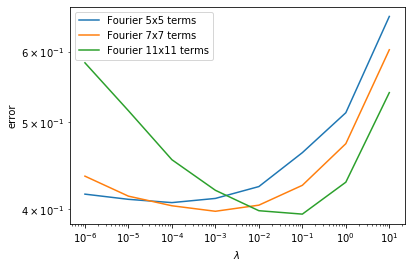

In [5]:
# Fix seed:
seed = 100
# Choose number of samples in the error estimation
n_samples = 20

for n in n_terms:
    lam_error = []
    for l in lambdas:
        print("Calculating error for {0}x{0} field, lambda = {1}".format(n, l))
        wf = FourierWindfield(shape = (n,n), reg_type = 'ridge', reg_param = l, div_param = 0)
        pred = do_random_predictions(wf, data, n_splits = 5, n_samples = n_samples, seed = seed, verbose = False)
        lam_error.append(get_mean_square_error(pred, normalize = True))
    plt.loglog(lambdas, lam_error, label = 'Fourier {0}x{0} terms'.format(n))

plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("error")

For these parameter ranges, it seems like increasing the number of Fourier terms results in decreased error, given that the regularisation constant $\lambda$ is chosen optimally. As more Fourier terms are introduced, the model probably eventually becomes overfitted and the error then starts increasing instead. The same process can of course be repeated with a finer grid to yield better results, albeit with longer running time. Let's stick with $11\times 11$ Fourier terms with the optimal $\lambda$ for the time being, and do the same type of grid search to find the optimal $\eta$.

Calculating error for eta = 1e-07
Calculating error for eta = 1e-06
Calculating error for eta = 1e-05
Calculating error for eta = 0.0001
Calculating error for eta = 0.001
Calculating error for eta = 0.01
Calculating error for eta = 0.1
Calculating error for eta = 1.0
Calculating error for eta = 10.0
Calculating error for eta = 100.0


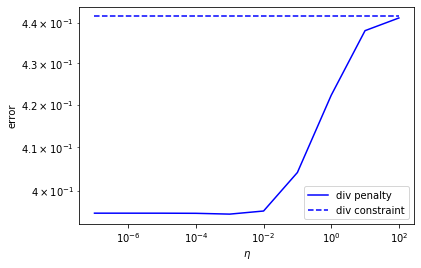

In [7]:
# Fix lambda:
lam = 10**(-1)
# Use fourier field with 11 x 11 terms.
n = 11
# Eta values to plot errors of
etas = np.logspace(-7, 2, 10) #


eta_error = []
for eta in etas:
    print("Calculating error for eta = {0}".format(eta))
    wf = FourierWindfield(shape = (n,n), reg_type = 'ridge', reg_param = lam, div_param = eta)
    pred = do_random_predictions(wf, data, n_splits = 5, n_samples = n_samples, seed = seed, verbose = False)
    eta_error.append(get_mean_square_error(pred, normalize = True))
    
# also test eta -> inf, meaning that zero divergence becomes a constraint.
eta = float('inf')
wf = FourierWindfield(shape = (n,n), reg_type = 'ridge', reg_param = lam, div_param = eta)
pred = do_random_predictions(wf, data, n_splits = 5, n_samples = n_samples, seed = seed, verbose = False)
inf_error = get_mean_square_error(pred, normalize = True)


# Plot results
plt.loglog(etas, eta_error, color = 'blue', label='div penalty') 
plt.loglog(etas, inf_error*np.ones(len(etas)), color = 'blue', linestyle = 'dashed', label='div constraint') 
plt.xlabel("$\eta$")
plt.ylabel("error")
plt.legend()

For the given regularisation $\lambda$, the divergence penalty does little to nothing for the error. A more accurate method for finding the optimal hyper parameters can be obtained by running a full grid search on a grid $(\lambda_i, \eta_i)$. See the `TUTORIAL-Windfield_scoring.ipynb` notebook for a guide on how to use mutithreading for faster grid searches. 